In [17]:
import pickle

import tarfile
from tqdm import tqdm_notebook as tqdm

from multiprocessing import Pool


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('russian')

from string import punctuation
# punkt= [p for p in punctuation] + ["`", "``" ,"''", "'"]
punkt= [p for p in punctuation] + ["`", "``" ,"''", "'", '"','""','"""','«','»']


import gensim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fasttext
import pymorphy3

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split


# !pip install MulticoreTSNE
# from sklearn.decomposition import TruncatedSVD
# from MulticoreTSNE import MulticoreTSNE as TSNE


## ==========================================================


In [18]:


# # Загрузка данных из файла
# df = pd.read_csv('shorted_data_combined.csv')



# # Удаление пунктуации и стоп-слов из колонки 'topic'
# df['topic'] = df['topic'].apply(
#     lambda x: ' '.join([word.lower() for word in nltk.word_tokenize(x) if word.lower() not in stop and word not in punkt])
# )

# # Сохранение измененных данных в новый файл
# df.to_csv('del_pun_stop_words.csv', index=False)


In [23]:
# from pymorphy3 import MorphAnalyzer
# import pymorphy3_dicts_ru
# # Создание объекта лемматизатора
# morph = MorphAnalyzer(path=pymorphy3_dicts_ru.get_path(),lang='ru')

# # Пример текста для лемматизации
# text1 = "Кошки любят  лазить по деревьям."
# text2 = "Кошки любят  лазить по деревьям."
# text = ' br '.join([text1,text2])
# # Лемматизация слов в тексте
# lemmatized_text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
# print(lemmatized_text.split('br'))


['кошка любить лазить по деревьям. ', ' кошка любить лазить по деревьям.']


In [ ]:
# df = pd.read_csv('shorted_data_combined.csv')

## ==========================================================

In [2]:
import pymorphy3_dicts_ru

dicts_path = pymorphy3_dicts_ru.get_path()

In [3]:
lemmatizer = pymorphy3.MorphAnalyzer(path=dicts_path,lang='ru')

In [4]:

data = pd.read_csv('lenta-ru-news.csv')

C:\Users\bandos\AppData\Local\Temp\ipykernel_5468\452840461.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('lenta-ru-news.csv')


In [5]:
data.date = pd.to_datetime(data.date)

In [6]:



# Получаем частоты встречаемости тем с нормализацией
topic_counts = data['topic'].value_counts()
topic_counts_normalized = data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
table = pd.DataFrame({'Тема': topic_counts.index, 'Количество новостей': topic_counts.values, 'Доля': topic_counts_normalized.values})

# Выводим таблицу
print(table)


                 Тема  Количество новостей      Доля
0              Россия               160445  0.217119
1                 Мир               136621  0.184880
2           Экономика                79528  0.107620
3               Спорт                64413  0.087166
4            Культура                53797  0.072800
5         Бывший СССР                53402  0.072265
6     Наука и техника                53136  0.071905
7      Интернет и СМИ                44663  0.060439
8            Из жизни                27605  0.037356
9                 Дом                21734  0.029411
10  Силовые структуры                19596  0.026518
11           Ценности                 7766  0.010509
12             Бизнес                 7399  0.010013
13        Путешествия                 6408  0.008671
14     69-я параллель                 1268  0.001716
15               Крым                  666  0.000901
16      Культпросвет                   340  0.000460
17            Легпром                  114  0.

Темы следующие (ниже дана тема и ее числовой код):

- 'Общество/Россия' : 0
- 'Экономика' : 1
- 'Силовые структуры' : 2
- 'Бывший СССР' : 3
- 'Спорт' : 4
- 'Забота о себе' : 5
- 'Строительство' : 6
- 'Туризм/Путешествия' : 7
- 'Наука и техника' : 8

In [6]:
selected_topics = ['Россия', 'Экономика', 'Силовые структуры', 'Бывший СССР', 'Спорт', 'Забота о себе', 'Строительство', 'Путешествия', 'Наука и техника']

filtered_data = data[data.topic.isin(selected_topics)]


In [ ]:
# Получаем частоты встречаемости тем с нормализацией
topic_counts = filtered_data['topic'].value_counts()
topic_counts_normalized = filtered_data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
filtered_table = pd.DataFrame({'Тема': topic_counts.index, 'Количество новостей': topic_counts.values, 'Доля': topic_counts_normalized.values})

# Выводим таблицу
print(filtered_table)

                Тема  Количество новостей      Доля
0             Россия               160445  0.367212
1          Экономика                79528  0.182016
2              Спорт                64413  0.147422
3        Бывший СССР                53402  0.122222
4    Наука и техника                53136  0.121613
5  Силовые структуры                19596  0.044849
6        Путешествия                 6408  0.014666


In [13]:
# Посчитать количество уникальных значений тем в отфильтрованных данных
unique_topics_count = filtered_data['topic'].nunique()

# Вывести количество
print(f'Количество уникальных тем в отфильтрованных данных: {unique_topics_count}/{len(selected_topics)}')

# Уникальные темы, которые не попали в отфильтрованный датасет
missing_topics = set(selected_topics) - set(filtered_data['topic'].unique())

# Вывести темы, которые не попали
print(f'Темы, которые не попали в отфильтрованный датасет: {missing_topics}')


Количество уникальных тем в отфильтрованных данных: 7/9
Темы, которые не попали в отфильтрованный датасет: {'Забота о себе', 'Строительство'}


<Axes: >

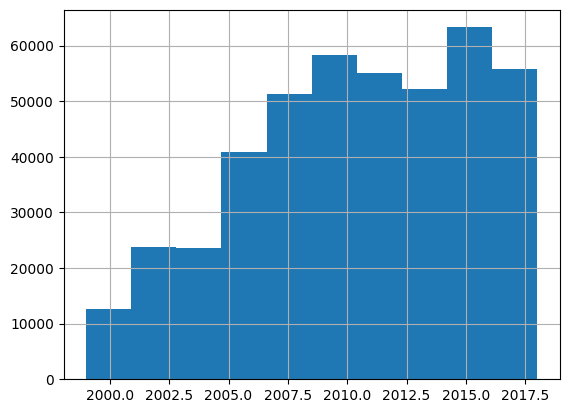

In [14]:
filtered_data.date.dt.year.hist()

In [7]:
# Задаем максимальное количество новостей для каждой темы
max_news_per_topic = 1000

# Группируем данные по теме и выбираем не более 1000 новостей из каждой темы
shorted_data = filtered_data.groupby('topic').sample(max_news_per_topic)

# Получаем частоты встречаемости тем в сокращенных данных с нормализацией
shorted_topic_counts = shorted_data['topic'].value_counts()
shorted_topic_counts_normalized = shorted_data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
shorted_table = pd.DataFrame({'Тема': shorted_topic_counts.index, 'Количество новостей': shorted_topic_counts.values, 'Доля': shorted_topic_counts_normalized.values})

# Выводим таблицу
print(shorted_table)


                Тема  Количество новостей      Доля
0        Бывший СССР                 1000  0.142857
1    Наука и техника                 1000  0.142857
2        Путешествия                 1000  0.142857
3             Россия                 1000  0.142857
4  Силовые структуры                 1000  0.142857
5              Спорт                 1000  0.142857
6          Экономика                 1000  0.142857


<Axes: >

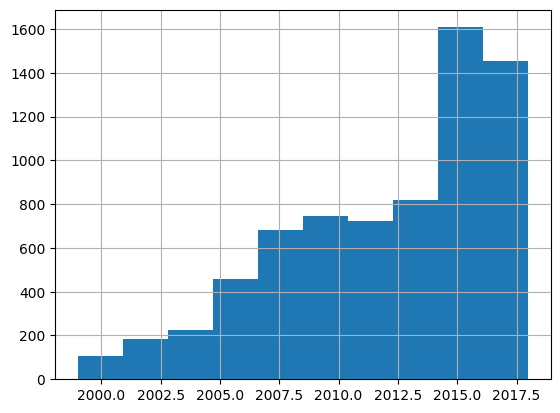

In [8]:
shorted_data.date.dt.year.hist()

In [15]:
topic_mapping = {
    'Россия': 0,
    'Экономика': 1,
    'Силовые структуры': 2,
    'Бывший СССР': 3,
    'Спорт': 4,
    'Забота о себе': 5,
    'Строительство': 6,
    'Путешествия': 7,
    'Наука и техника': 8
}

# Заменить значения в колонке 'topic' на их числовые представления из словаря
filtered_data['topic'] = filtered_data['topic'].replace(topic_mapping)



C:\Users\bandos\AppData\Local\Temp\ipykernel_40248\2629722879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['topic'] = filtered_data['topic'].replace(topic_mapping)


### Обрезаем dataframe (shorted_data)

In [9]:
shorted_data = shorted_data[['title','topic']]

In [10]:
shorted_data.head(3)

,title,topic
343123,Глава латвийских католиков вступился за русски...,Бывший СССР
663312,Порошенко показали старт новейшей украинской р...,Бывший СССР
272328,Ющенко уволил пятерых заместителей мэра Киева,Бывший СССР


### Создаем новый csv

In [40]:
# Задайте путь к файлу CSV, в который вы хотите записать данные
csv_filename = "shorted_data.csv"

# Записываем DataFrame в файл CSV
shorted_data.to_csv(csv_filename, index=False)

print(f"Data has been successfully written to {csv_filename}.")


Data has been successfully written to shorted_data.csv.


### Добавляем пропущенные темы:

In [41]:
import pandas as pd

# Загрузите данные из titles_health_rbc_unique.csv
health_data = pd.read_csv('titles_health_rbc_unique.csv')

# Предположим, что у вас уже есть DataFrame shorted_data и health_data

# Добавьте новый столбец 'topic' в health_data с заданным значением 'Забота о себе'
health_data['topic'] = 'Забота о себе'

# Добавьте данные из health_data в shorted_data
shorted_data = pd.concat([shorted_data, health_data], ignore_index=True)

# Задайте путь к файлу CSV, в который вы хотите записать объединенные данные
csv_filename_combined = "shorted_data_combined.csv"

# Записываем объединенные данные в файл CSV
shorted_data.to_csv(csv_filename_combined, index=False)

print(f"Combined data has been successfully written to {csv_filename_combined}.")


Combined data has been successfully written to shorted_data_combined.csv.


In [43]:


import pandas as pd

# Загрузите данные из titles_health_rbc_unique.csv
stroitelstvo_data = pd.read_csv('titles_Stroitelstvo_ria_unique.csv')

# Предположим, что у вас уже есть DataFrame shorted_data и health_data

# Добавьте новый столбец 'topic' в stroitelstvo_data с заданным значением 'Строительство'
stroitelstvo_data['topic'] = 'Строительство'

# Добавьте данные из health_data в shorted_data
shorted_data = pd.concat([shorted_data, stroitelstvo_data], ignore_index=True)

# Задайте путь к файлу CSV, в который вы хотите записать объединенные данные
csv_filename_combined = "shorted_data_combined.csv"

# Записываем объединенные данные в файл CSV
shorted_data.to_csv(csv_filename_combined, index=False)

print(f"Combined data has been successfully written to {csv_filename_combined}.")

Combined data has been successfully written to shorted_data_combined.csv.


In [44]:
shorted_data = pd.read_csv('shorted_data_combined.csv')

In [45]:
# Получаем частоты встречаемости тем с нормализацией
topic_counts = shorted_data['topic'].value_counts()
topic_counts_normalized = shorted_data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
shorted_table = pd.DataFrame({'Тема': topic_counts.index, 'Количество новостей': topic_counts.values, 'Доля': topic_counts_normalized.values})

# Выводим таблицу
print(shorted_table)

                Тема  Количество новостей      Доля
0      Забота о себе                 2679  0.250491
1      Строительство                 1016  0.094998
2        Бывший СССР                 1000  0.093502
3    Наука и техника                 1000  0.093502
4        Путешествия                 1000  0.093502
5             Россия                 1000  0.093502
6  Силовые структуры                 1000  0.093502
7              Спорт                 1000  0.093502
8          Экономика                 1000  0.093502


In [46]:
# Задаем максимальное количество новостей для каждой темы
max_news_per_topic = 1000

# Группируем данные по теме и выбираем не более 1000 новостей из каждой темы
shorted_data = shorted_data.groupby('topic').sample(max_news_per_topic)

# Получаем частоты встречаемости тем в сокращенных данных с нормализацией
shorted_topic_counts = shorted_data['topic'].value_counts()
shorted_topic_counts_normalized = shorted_data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
shorted_table = pd.DataFrame({'Тема': shorted_topic_counts.index, 'Количество новостей': shorted_topic_counts.values, 'Доля': shorted_topic_counts_normalized.values})

# Выводим таблицу
print(shorted_table)

                Тема  Количество новостей      Доля
0        Бывший СССР                 1000  0.111111
1      Забота о себе                 1000  0.111111
2    Наука и техника                 1000  0.111111
3        Путешествия                 1000  0.111111
4             Россия                 1000  0.111111
5  Силовые структуры                 1000  0.111111
6              Спорт                 1000  0.111111
7      Строительство                 1000  0.111111
8          Экономика                 1000  0.111111


Темы следующие (ниже дана тема и ее числовой код):

- 'Общество/Россия' : 0
- 'Экономика' : 1
- 'Силовые структуры' : 2
- 'Бывший СССР' : 3
- 'Спорт' : 4
- 'Забота о себе' : 5
- 'Строительство' : 6
- 'Туризм/Путешествия' : 7
- 'Наука и техника' : 8

In [47]:
topic_mapping = {
    'Россия': 0,
    'Экономика': 1,
    'Силовые структуры': 2,
    'Бывший СССР': 3,
    'Спорт': 4,
    'Забота о себе': 5,
    'Строительство': 6,
    'Путешествия': 7,
    'Наука и техника': 8
}

# Заменить значения в колонке 'topic' на их числовые представления из словаря
shorted_data['topic'] = shorted_data['topic'].replace(topic_mapping)

In [16]:
filtered_data.head(3)

,title,topic
5,"Космонавты сомневаются в надежности ""Мира""",Россия
6,Взрыв в центре Москвы: пострадало 30 человек,Россия
7,Япония кредитует Россию на полтора миллиарда д...,Россия


In [48]:
shorted_data.head(3)

,title,topic
780,Патаркацишвили снимет свою кандидатуру за день...,3
396,В результате наводнения под Одессой погибли дв...,3
686,Глава львовских католиков призвал украинцев по...,3


In [49]:
# Задаем максимальное количество новостей для каждой темы
max_news_per_topic = 1000

# Группируем данные по теме и выбираем не более 1000 новостей из каждой темы
shorted_data = shorted_data.groupby('topic').sample(max_news_per_topic)

# Получаем частоты встречаемости тем в сокращенных данных с нормализацией
shorted_topic_counts = shorted_data['topic'].value_counts()
shorted_topic_counts_normalized = shorted_data['topic'].value_counts(normalize=True)

# Преобразуем Series в DataFrame
shorted_table = pd.DataFrame({'Тема': shorted_topic_counts.index, 'Количество новостей': shorted_topic_counts.values, 'Доля': shorted_topic_counts_normalized.values})

# Выводим таблицу
print(shorted_table)

   Тема  Количество новостей      Доля
0     0                 1000  0.111111
1     1                 1000  0.111111
2     2                 1000  0.111111
3     3                 1000  0.111111
4     4                 1000  0.111111
5     5                 1000  0.111111
6     6                 1000  0.111111
7     7                 1000  0.111111
8     8                 1000  0.111111


In [17]:
# Получаем частоты встречаемости тем с нормализацией
filtered_topic_counts_normalized = filtered_data.topic.value_counts(normalize=True)

# Преобразуем Series в DataFrame
filtered_table = pd.DataFrame({'Тема': filtered_topic_counts_normalized.index, 'Доля': filtered_topic_counts_normalized.values})

# Выводим таблицу
print(filtered_table)

   Тема      Доля
0     0  0.367212
1     1  0.182016
2     4  0.147422
3     3  0.122222
4     8  0.121613
5     2  0.044849
6     7  0.014666


In [18]:
filtered_data.size

2621568

In [19]:
data.size

4805850

In [20]:
filtered_data.size/data.size

0.5454951777521146

In [21]:
filtered_data[filtered_data.topic.isna()]

,url,title,text,topic,tags,date


In [22]:
news_title = filtered_data['title']
news_text = filtered_data['text']
news_topic = filtered_data['topic']

In [51]:

shorted_news_title = shorted_data['title']
shorted_news_topic = shorted_data['topic']

In [52]:
def tokenize(sent):
    try:
        sent = word_tokenize(sent)
        return [word for word in sent if word not in stop and word not in punkt]
    
    except:
        return []
    
def lemmatize(sent):
    try:
        return " ".join([lemmatizer.normal_forms(word)[0] for word in sent])
    except:
        return " "

    
# def preprocess_sent(sent):
#     return lemmatize(tokenize(sent))


def preprocess_sent(sent):
    try:
        tokenized_sent = tokenize(sent)
        lemmatized_sent = lemmatize(tokenized_sent)
        return lemmatized_sent
    except Exception as e:
        print(f"Error in preprocess_sent: {e}")
        return " "

In [24]:
s = news_text[:2].tolist()

In [25]:
preprocess_sent(s[0])

'как стать известно агентство ассошиэйтед пресс экипаж последний экспедиция станция мир считать способный выйти из-под контроля.командир виктор афанасьев сказать мы чувствовать грустить оставить станция летать беспилотный режим gazeta ru подробно писать финансирование программа мир закрытый конструктор спешить топить тихий океан надеяться изыскание внебюджетный средств.онить надеяться правительство оплатить финальный экспедиция мир февраль март 2000 год новый экспедиция должный постепенно перевести станция низкий орбита 140- тонный мир основное сгореть атмосфера незначительный часть упасть тихий океан но никакой гарантия пережить столько отказ оборудование конструкция повести адекватно команда афанасьев перечислить потенциально опасный элемент мир пресс- конференция состояться понедельник звёздный городок мочь упасть давление кабина сказать это стать серьёзный препятствие работа следующий экспедиция слишком большой роль человеческий фактор элементарный ошибка привести потеря топливо по

In [26]:
## ОЧЕНЬ ДОЛГО ИДЕТ ПРЕДОБРАБОТКА...
# titles_preprocessed = news_title.tolist()
# for num,item in enumerate(titles_preprocessed):
#     titles_preprocessed[num] = preprocess_sent(item)

In [27]:
# from multiprocessing import Pool

# # Замените Pool(8) на количество процессов, которое вы хотите использовать
# with Pool(8) as p:
#     # Примените функцию preprocess_sent ко всем элементам списка news_title
#     titles_preprocessed = list(p.imap(preprocess_sent, news_title.tolist()))

#  дольше 4 ч...
# Итог: будем играть по грязному...

In [53]:




# from multiprocessing import Pool

# # Замените Pool(8) на количество процессов, которое вы хотите использовать
# with Pool(8) as p:
#     # Примените функцию preprocess_sent ко всем элементам списка news_title
#     titles_preprocessed = list(p.imap(preprocess_sent, shorted_news_title.tolist()))


#  дольше 4 ч...
# Итог: пойдем другим путем...

In [ ]:
# y = shorted_news_topic.tolist()

In [28]:
titles_preprocessed = news_title.tolist()

In [29]:
y = news_topic.tolist()

In [ ]:
title_train, title_test, y_train, y_test = train_test_split(titles_preprocessed, y, test_size=0.25, stratify=y, random_state=33)

In [ ]:
with open('train_data_titles.txt', 'w+', encoding='utf-8') as tr:
    for idx in range(len(title_train)):
        # tr.write('__label__' + y_train[idx]+' '+title_train[idx]+'\n')
        tr.write('__label__' + f'{y_train[idx]}'+' '+title_train[idx]+'\n')
        
with open('test_data_titles.txt', 'w+', encoding='utf-8') as te:
    for idx in range(len(title_test)):
        # te.write('__label__' + y_test[idx]+' '+title_test[idx]+'\n')        
        te.write('__label__' + f'{y_test[idx]}'+' '+title_test[idx]+'\n')    
print('Все записано!')

In [32]:
%%time
ft_model = fasttext.train_supervised(input='train_data_titles.txt')

CPU times: total: 40.5 s
Wall time: 12.6 s


In [33]:
ft_model.predict(preprocess_sent('Акула съела банкира: акции банка упали на 25%'), k=1)

(('__label__1',), array([0.96383053]))

In [34]:
ft_model.predict(preprocess_sent('Кремль обеспокоен: висит груша, нельзя скушать'), k=3)

(('__label__0', '__label__8', '__label__1'),
 array([0.96044654, 0.02341335, 0.0081215 ]))

In [35]:
ft_model.predict(preprocess_sent('В Австралии перестали интересоваться футболом'), k=3)

(('__label__4', '__label__8', '__label__0'),
 array([9.95801687e-01, 4.06434899e-03, 1.07983869e-04]))

In [36]:
ft_model.test('test_data_titles.txt', k=1)

(109232, 0.8509136516771642, 0.8509136516771642)

In [37]:
%%time
ft_model_p1 = fasttext.train_supervised(input='train_data_titles.txt', epoch=10, wordNgrams=2, loss='hs', lr=1.0)

CPU times: total: 1min 48s
Wall time: 34.4 s


In [38]:
# ft_model_p1.test('test_data_titles.txt',k=1)
ft_model_p1.test('test_data_titles.txt')

(109232, 0.8305533177090962, 0.8305533177090962)

In [39]:
# Тестирование модели
predictions = ft_model_p1.predict('test_data_titles.txt')[0]
# predicted_labels = [int(label[0][-1]) for label in predictions]
predicted_labels = [label for label in predictions]
predicted_labels

['__label__8']

### Следующий метод работает лучше на 0.01 (но скорость обучения значительно дольше..)

In [40]:
# %%time
# ft_model_p_o = fasttext.train_supervised(input='train_data_titles.txt', autotuneValidationFile='test_data_titles.txt')

# # CPU times: total: 23min 31s
# # Wall time: 5min 43s

In [41]:
# ft_model_p_o.test('test_data_titles.txt')

In [42]:
# print(f'Best learning rate: {ft_model_p_o.lr} \nBest epochs: {ft_model_p_o.epoch} \nBest_word_Ngrams: {ft_model_p_o.wordNgrams}')

In [43]:
## ft_model_p_o.save_model('lenta_titles_ft_model.bin')

## Теперь работаем с пердоставленными тестовыми данными

In [46]:
test_data = pd.read_csv('test_news.csv')

In [57]:
test_data.head(10)

,content
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...
1,В начале февраля 2023 года в Пушкинском районе...
2,Фото: Andy Bao / Getty Images Анастасия Борисо...
3,"Если вы хотели, но так и не съездили на море л..."
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...
5,Фото: Viacheslav Ratynskyi / Reuters Варвара К...
6,Скриншот: YouTube-канал Gulag.net Управление С...
7,Фото: РИА Новости Алевтина Запольская Закарпат...
8,Фото: @vrogov / Telegram Марина Совина Российс...
9,Фото: Эдуард Эрбен / РИА Новости Алевтина Запо...


In [51]:
test_data.size

26275

In [61]:
# Предсказание меток для каждого заголовка новости
predicted_labels = []
for title in test_data['content']:  # Замените 'content' на реальное имя столбца с заголовками
    # Удаление символа новой строки, если он присутствует
    title = title.replace('\n', ' ')
    # Предсказание меток
    labels, probs = ft_model_p1.predict(title)
    # print(labels, probs)
    predicted_labels.append(labels[0])

# Добавление предсказанных меток в тестовые данные
test_data['predicted_label'] = predicted_labels

# Вывод результата
print(test_data[['content', 'predicted_label']])

                                                 content predicted_label
0      Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...      __label__0
1      В начале февраля 2023 года в Пушкинском районе...      __label__1
2      Фото: Andy Bao / Getty Images Анастасия Борисо...      __label__4
3      Если вы хотели, но так и не съездили на море л...      __label__0
4      Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...      __label__4
...                                                  ...             ...
26270  Фото: РИА Новости Алевтина Запольская Главное ...      __label__0
26271  Вадим Гутцайт Фото: Sergei CHUZAVKOV / Europea...      __label__3
26272  Фото: Олег Харсеев / Коммерсантъ Александр Кур...      __label__0
26273  Владимир Зеленский Фото: Yves Herman / Reuters...      __label__3
26274  Фото: President of the Republic of Azerbaijan ...      __label__3

[26275 rows x 2 columns]


In [64]:
# Создание DataFrame с результатами
pre_result_df = pd.DataFrame({'content': test_data['content'], 'predicted_label': predicted_labels})

pre_result_df.head()

,content,predicted_label
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...,__label__0
1,В начале февраля 2023 года в Пушкинском районе...,__label__1
2,Фото: Andy Bao / Getty Images Анастасия Борисо...,__label__4
3,"Если вы хотели, но так и не съездили на море л...",__label__0
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...,__label__4


In [63]:
# Запись результатов в Excel
# pre_result_df.to_excel('predicted_labels.xlsx', index=False)

In [83]:
pre_result_df['topic'] = pre_result_df['predicted_label'].str.replace('__label__', '').astype(int)
pre_result_df['index'] = pre_result_df.index
pre_result_df.head()

,content,predicted_label,topic,index
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...,__label__0,0,0
1,В начале февраля 2023 года в Пушкинском районе...,__label__1,1,1
2,Фото: Andy Bao / Getty Images Анастасия Борисо...,__label__4,4,2
3,"Если вы хотели, но так и не съездили на море л...",__label__0,0,3
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...,__label__4,4,4


In [85]:
result_df = pre_result_df[['topic','index']].copy()

result_df.head()


,topic,index
0,0,0
1,1,1
2,4,2
3,0,3
4,4,4


In [86]:
result_df.to_csv('result.csv', index=False)